In [3]:

# Utilizaremos este cuaderno para explorar los modelos ARIMA

# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import shutil
import os
import matplotlib.pyplot as plt
# from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from statsmodels.tsa.seasonal import seasonal_decompose
# from sklearn.metrics import mean_squared_error

# Cargamos los datos
path = '../datos/imputados/MAGDALENA_MEDIO/'

path_output = '../datos/TSW/MAGDALENA_MEDIO/'

shutil.rmtree(f'../datos/TSW/MAGDALENA_MEDIO/', ignore_errors=True)

#hacemos un ls de la carpeta
for file in os.listdir(path):
    print(file)
    col = file.split('.')[0]
    print(col)
    df = pd.read_csv(path+file)
    print(df[df[col]==-99999.0].count())
    df_2 = pd.DataFrame(data=[col,f"{df.shape[0]} {df["Año"].min()} 1 12"], columns=[col])

    df = df[col]
    # Concatenamso los dataframes
    path_output_2 = path_output+col
    df = pd.concat([df_2, df], axis=0)
    os.makedirs(path_output_2)
    df.to_csv(path_output_2+'/'+col+'_1.csv', index=False, header=False)
    break

23010020.csv
23010020
Fecha       18
Mes         18
Año         18
23010020    18
dtype: int64


Empezamos revisando si la serie de tiempo es estacionaria

23060150.csv


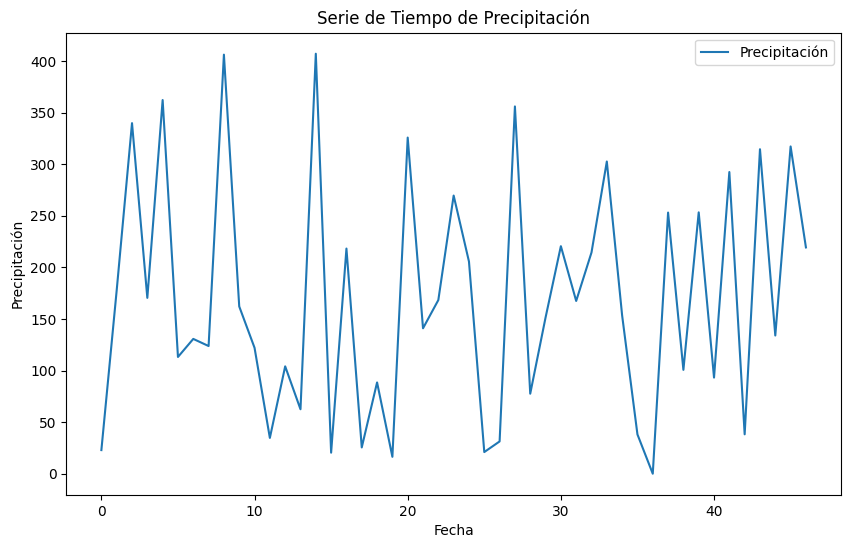

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
path = '../datos/imputados/MAGDALENA_MEDIO/'

# path_output = '../datos/TSW/MAGDALENA_MEDIO/'
# shutil.rmtree(f'../datos/TSW/MAGDALENA_MEDIO/', ignore_errors=True)

#hacemos un ls de la carpeta
file_test = os.listdir(path)[15]
print(file_test)
col = file_test.split('.')[0]

df = pd.read_csv(path+file_test)

df[col] = df[col].replace(-99999.0, np.nan)

# Graficar la serie de tiempo con el eje x siendo cada dato mensual
# agregamos el valor de cada thickness
plt.figure(figsize=(10, 6))
plt.plot(df[col][0:48], label='Precipitación')
plt.title('Serie de Tiempo de Precipitación')
plt.xlabel('Fecha')
plt.ylabel('Precipitación')
plt.legend()
plt.show()

Visualmente podemos apreciar como si se ve una tendencia estacional que se repite cada 12 datos(es decir cada año), pero igualmente le pasamos una Prueba de Dickey-Fuller Aumentada (ADF) utilizando la libreria statsmodels

In [19]:
!pip install statsmodels

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/9.8 MB 14.2 MB/s eta 0:00:01
   -------- ------------------------------- 2.2/9.8 MB 27.6 MB/s eta 0:00:01
   --------------- ------------------------ 3.9/9.8 MB 31.2 MB/s eta 0:00:01
   ------------------------ --------------- 5.9/9.8 MB 34.3 MB/s eta 0:00:01
   ------------------------------ --------- 7.6/9.8 MB 34.7 MB/s eta 0:00:01
   -------------------------------------- - 9.5/9.8 MB 35.8 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 31.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/233.9 kB ? eta -:--:--
   --------------------------------------- 233.9/233.9 kB 14.0 MB/s eta 0:00:00
   -------------

In [5]:
from statsmodels.tsa.stattools import adfuller

# Realizar la prueba ADF
result = adfuller(df[col].dropna())

# Mostrar los resultados
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -4.808668189705773
p-value: 5.2347014238834414e-05
Critial Values:
   1%, -3.4604283689894815
Critial Values:
   5%, -2.874768966942149
Critial Values:
   10%, -2.57382076446281


Dados los valores que encontramos, ADF es más negativa que todos los valores críticos (tanto al 1%, 5% y 10%) y un el valor p es extremadamente bajo, podemos concluir que la serie de tiempo es estacionaria, razon por la cual no necesitamos diferenciación y por lo mismo podemos asignar el valor 0 al término D del modelo ARIMA. Ahora se procede a identificar el grado de autocorrelacion parcial para hayar el valor del término P. Realizar este proceso es importante porque la PACF muestra la correlación entre una serie de tiempo y sus propios retrasos, eliminando la influencia de los términos intermedios.

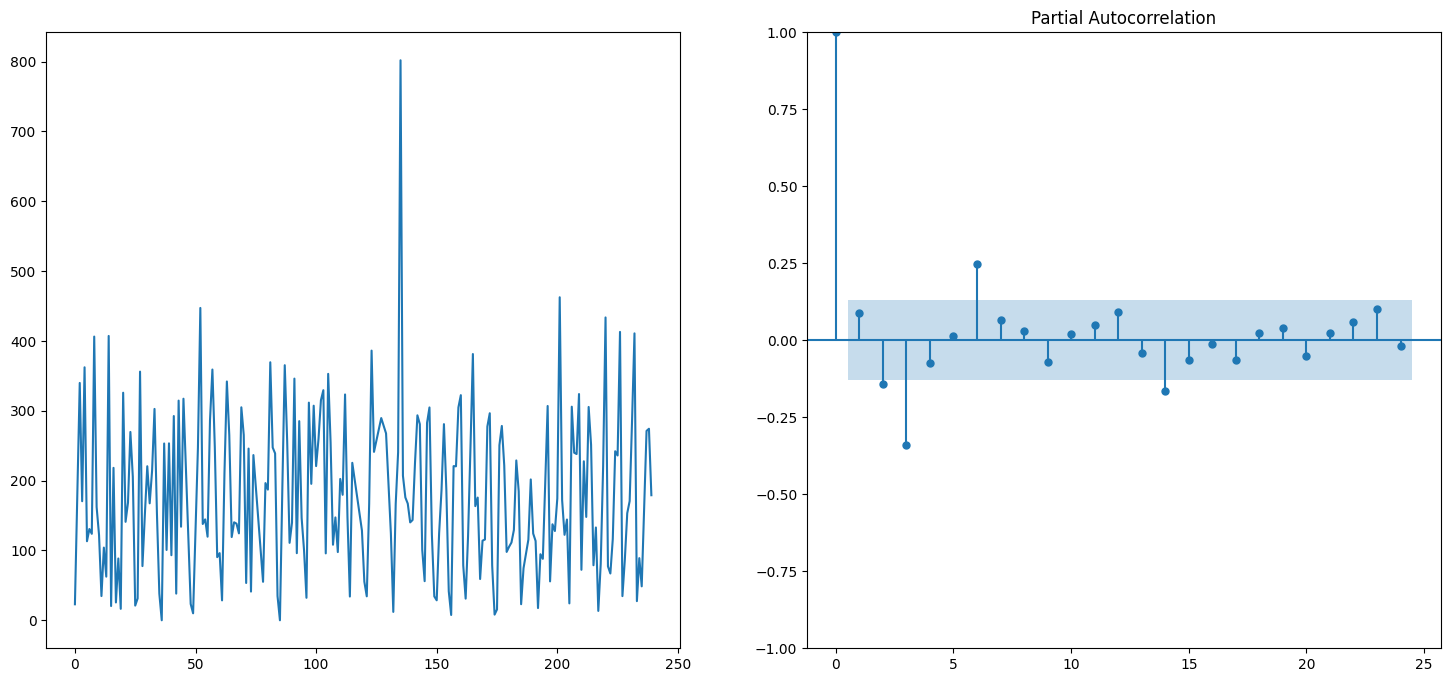

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(18, 8))
ax[0].plot(df[col].dropna())
plot_pacf(df[col].dropna(), ax=ax[1])
plt.show()

De esta ultima grafica, la linea azul sombreada marca el intervalo de confianza, la PACF muestra un valor significativamente diferente de cero en el primer retraso (lag 1) y luego parece caer dentro de la banda de confianza.
Algunos picos pequeños en retrasos posteriores (por ejemplo, lag 6 y otros más adelante) también parecen ser significativos, pero estos son menos pronunciados.

p: El valor más adecuado para p sería 1, ya que el primer retraso (lag 1) es claramente significativo y después de eso, la PACF cae dentro de la banda de confianza y se mantiene allí.
Entonces, podemos decir que el valor p para esta serie de tiempo, basado en la gráfica de autocorrelación parcial proporcionada, es 𝑝 = 1